In [ ]:
!pip install imbalanced-learn

⏳ Loading & Aggregating Data...
🔹 Condensed 6474 events into 562 Unique Issues.

⚖️ Applying SMOTE (k=3)...
🚀 Training XGBoost Classifier...

🏆 Aggregated Accuracy: 85.84%

📝 Classification Report:
              precision    recall  f1-score   support

     No Risk       0.38      0.38      0.38        13
         Low       0.92      0.92      0.92        95
        High       1.00      1.00      1.00         4
    Critical       1.00      1.00      1.00         1

    accuracy                           0.86       113
   macro avg       0.83      0.83      0.83       113
weighted avg       0.86      0.86      0.86       113



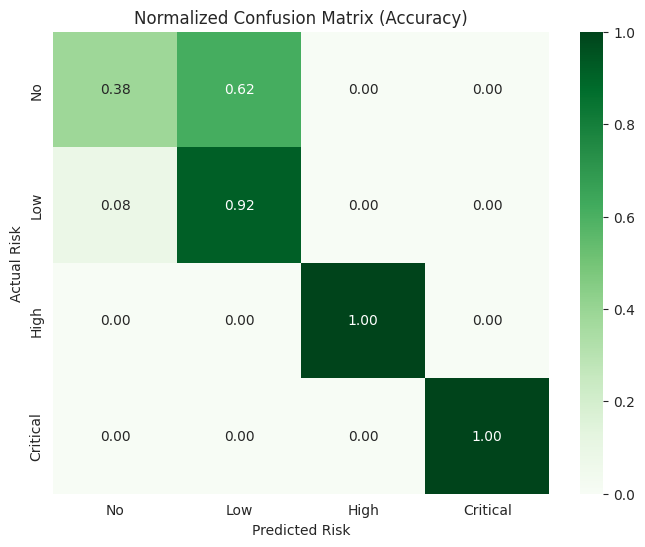

In [ ]:
# =============================================================================
# 🎯 IMPROVED SCHEDULE RISK MODEL (AGGREGATED & BALANCED)
# =============================================================================
# KEY IMPROVEMENTS:
# 1. Aggregation: Condenses Event Stream -> Unique Issues (Removes Data Leakage).
# 2. Dynamic SMOTE: Balances classes safely even with small sample sizes.
# 3. Workload Proxy: Calculates 'Author Load' based on total assigned points.
# =============================================================================

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# 1. LOAD & CLEAN DATA
# ==========================================
print("⏳ Loading & Aggregating Data...")
df = pd.read_csv('agile_event_stream_dataset_6k.csv')

# Handle missing/invalid Story Points
df['Story_Point'] = df['Story_Point'].replace(-1, np.nan)
df['Story_Point'] = df['Story_Point'].fillna(df['Story_Point'].median())

# 2. AGGREGATE TO ISSUE LEVEL (CRITICAL STEP)
# We flatten the stream to get the "Final State" or "Max State" of each ticket.
# This prevents the model from memorizing intermediate updates.
df_unique = df.groupby('Issue_ID').agg({
    'is_spillover': 'max',          # Did it EVER spill over?
    'Priority': 'first',            # Static Property
    'Type': 'first',                # Static Property
    'Story_Point': 'max',           # Max Estimate
    'total_links': 'max',           # Max Complexity
    'total_comments': 'max',        # Max Confusion
    'Author_ID': 'first',           # Assignee
    'days_since_sprint_start': 'mean' # Avg time position in sprint
}).reset_index()

print(f"🔹 Condensed {len(df)} events into {len(df_unique)} Unique Issues.")

# 3. FEATURE ENGINEERING
# ==========================================

# A. Risk Target Definition
def calculate_risk_level(row):
    # If it didn't spill over, Risk is 0
    if row['is_spillover'] == 0:
        return 0

    # If it DID spill over, Risk Level depends on Priority
    p = str(row['Priority'])
    if p in ['Blocker', 'Critical', 'Highest']:
        return 3 # Critical Risk
    elif p in ['High', 'Major']:
        return 2 # High Risk
    else:
        return 1 # Low Risk (Spillover but minor)

df_unique['risk_level'] = df_unique.apply(calculate_risk_level, axis=1)

# B. Workload Proxy (Author Level)
# "How much total work is this person carrying in the dataset?"
author_load = df_unique.groupby('Author_ID')['Story_Point'].sum().to_dict()
df_unique['author_total_load'] = df_unique['Author_ID'].map(author_load)

# C. Complexity & Pressure Features
# Link Density: Is this a small task with MANY dependencies? (High Risk)
df_unique['link_density'] = df_unique['total_links'] / (df_unique['Story_Point'] + 1)
# Comment Density: Is there too much discussion?
df_unique['comment_density'] = df_unique['total_comments'] / (df_unique['Story_Point'] + 1)
# Pressure: Points per remaining day (Estimate)
df_unique['days_remaining'] = 14 - df_unique['days_since_sprint_start']
df_unique['pressure_index'] = df_unique['Story_Point'] / (df_unique['days_remaining'].clip(lower=0.1))

# D. Encoding
le_type = LabelEncoder()
df_unique['Type_Code'] = le_type.fit_transform(df_unique['Type'].astype(str))

le_prio = LabelEncoder()
df_unique['Priority_Code'] = le_prio.fit_transform(df_unique['Priority'].astype(str))

# 4. PREPARE FOR TRAINING
# ==========================================
features = [
    'Story_Point', 'total_links', 'total_comments',
    'author_total_load', 'link_density', 'comment_density', 'pressure_index',
    'Type_Code', 'Priority_Code'
]
X = df_unique[features]
y = df_unique['risk_level']

# Impute (Just in case)
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=features)

# Split (Stratify is important due to class imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. SMOTE BALANCING
# ==========================================
# We adjust k_neighbors because some classes might have < 5 samples after split
min_samples = y_train.value_counts().min()
k_neighbors = min(min_samples - 1, 3)
if k_neighbors < 1: k_neighbors = 1

print(f"\n⚖️ Applying SMOTE (k={k_neighbors})...")
smote = SMOTE(k_neighbors=k_neighbors, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 6. TRAIN XGBOOST
# ==========================================
print("🚀 Training XGBoost Classifier...")

model = xgb.XGBClassifier(
    objective='multi:softmax',   # Softmax for multi-class
    num_class=4,
    n_estimators=300,
    learning_rate=0.05,          # Slower learning for stability
    max_depth=6,
    subsample=0.8,               # Prevent overfitting
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_res, y_train_res)

# 7. EVALUATION
# ==========================================
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n🏆 Aggregated Accuracy: {acc:.2%}")
print("\n📝 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Risk', 'Low', 'High', 'Critical'], zero_division=0))

# 8. VISUALIZATION
# ==========================================
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
# Normalize to see percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=['No', 'Low', 'High', 'Critical'],
            yticklabels=['No', 'Low', 'High', 'Critical'])
plt.title('Normalized Confusion Matrix (Accuracy)')
plt.ylabel('Actual Risk')
plt.xlabel('Predicted Risk')
plt.show()

In [ ]:
import joblib

# ==========================================
# 6. SAVE MODEL & ARTIFACTS
# ==========================================
# We must save the Encoders & Imputers too, or the model won't work on new data.

# 1. Save the AI Model (The Brain)
joblib.dump(model, 'schedule_risk_model.pkl')

# 2. Save the Interpreters (The Translators)
# These convert "Critical", "Bug" -> [4, 1] for the AI
artifacts = {
    'imputer': imputer,         # Handles missing values
    'le_type': le_type,         # Converts Type (Story/Bug) to numbers
    'le_prio': le_prio,         # Converts Priority to numbers
    'author_load': author_load  # Map of Author Workloads
}
joblib.dump(artifacts, 'risk_artifacts.pkl')

print("\n💾 Model saved as 'schedule_risk_model.pkl'")
print("💾 Artifacts saved as 'risk_artifacts.pkl'")


💾 Model saved as 'schedule_risk_model.pkl'
💾 Artifacts saved as 'risk_artifacts.pkl'
